In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import copy
import time
import pandas as pd
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [10]:
x=torch.rand(10,50)
W1=nn.Parameter(torch.randn(128,50))
print(W1)
print('\n\n')
print(W1.shape)
print(W1.t().shape)
print('\n\n')
y=x@W1.T
print(y.shape)



Parameter containing:
tensor([[-0.1254, -0.2938,  0.8211,  ...,  0.3244,  0.1303,  2.0217],
        [ 1.4139, -0.7889, -0.0187,  ..., -1.0615,  0.5372, -0.6197],
        [ 1.1567,  1.0456,  1.2634,  ..., -0.6547,  0.5813, -0.8994],
        ...,
        [ 0.3630,  0.5090, -0.4930,  ..., -0.7259,  0.3692, -0.4345],
        [ 0.2923, -0.9554,  0.8411,  ...,  0.9519,  0.2278,  1.2198],
        [-0.3227, -0.0374, -1.1659,  ...,  0.9966, -1.1394, -0.4707]],
       requires_grad=True)



torch.Size([128, 50])
torch.Size([50, 128])



torch.Size([10, 128])


In [15]:
W2=nn.Linear(128,50)

print(W2)
print('\n\n')
print(W2.weight.shape)
print(W2.weight.T.shape)
print('\n\n')
y=x@W2.weight
print(y.shape)




Linear(in_features=128, out_features=50, bias=True)



torch.Size([50, 128])
torch.Size([128, 50])



torch.Size([10, 128])


In [16]:
dir(nn.Linear)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_call_impl',
 '_get_backward_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'get_buffer',
 'get_extra_state',
 'get_parameter',
 'get_submodule'

In [21]:
??nn.Linear.__init__()

Object `nn.Linear.__init__()` not found.


In [30]:
data=pd.read_csv('mnist_train.csv')
idx=np.random.choice(data.index,20000)
data=data.iloc[idx]
data.reset_index(inplace=True)
data.drop(columns='index',inplace=True)
labels=data.iloc[:,0]
data=data.iloc[:, 1:]
dataNorm=data/np.max(data,axis=0)
dataNorm.fillna(0,inplace=True)
dataT=torch.tensor(np.array(dataNorm)).float()




In [31]:
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)
      
      ### encoder layer
      self.enc = nn.Parameter(torch.randn(50,128))

      ### latent layer
      # self.lat = nn.Linear(15,150)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x=x.t()
      x=F.relu(self.enc@x)
      
      x = F.relu( self.enc.t()@x )
      x = x.t()
      y = torch.sigmoid( self.dec(x) )
      return y
  
  # create the model instance
  net = aenet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [32]:
net,lossfun,optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)

print('Input shape:')
print(X.shape)
print(' ')

Input shape:
torch.Size([5, 784])
 


In [33]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10000
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # select a random set of images
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]

    # forward pass and loss
    yHat = net(X)[0] # NEW! here we only care about the final model output
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net
     

c:\Users\arvin\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([32, 784])) that is different to the input size (torch.Size([784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Final loss: 0.0704


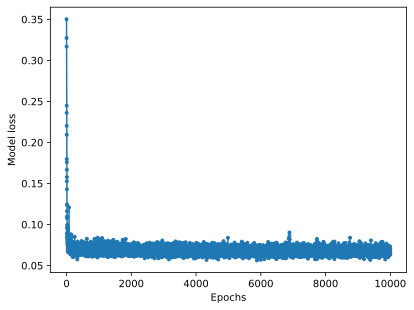

In [34]:
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()


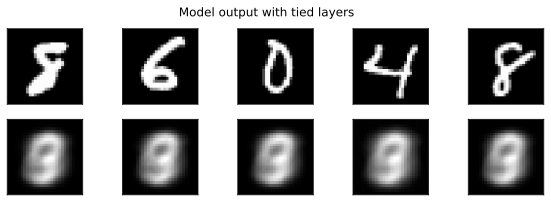

In [35]:

# Visualization of inputs and outputs
X = dataT[:5,:]
yHat = net(X)


# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.suptitle('Model output with tied layers')
plt.show()

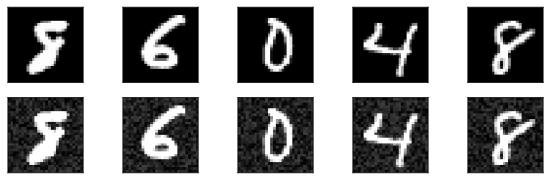

In [36]:

# grab a small set of images
X = dataT[:10,:]

# add noise
Xnoise = X + torch.rand_like(X)/4

# clip at 1
Xnoise[Xnoise>1] = 1


# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.show()
     

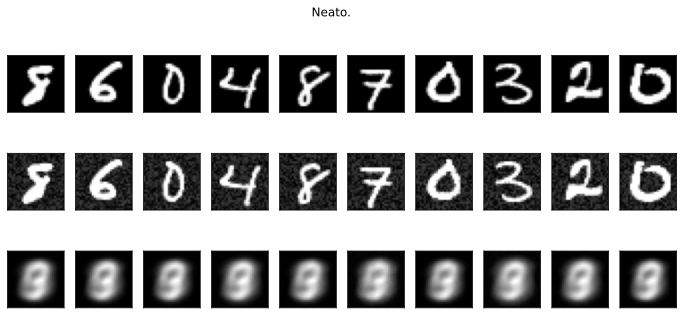

In [37]:
# run through the model
Y = net(Xnoise)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(12,5))

for i in range(10):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])
  
plt.suptitle('Neato.')
plt.show()
     
